In [1]:
import geopandas as gpd
import rasterio
from rasterio.mask import mask

# metodo de clasificacion
import jenkspy

In [2]:
import numpy as np

In [3]:
# Cargar el shapefile que contiene el polígono para el recorte
shapefile_path = r'G:\OneDrive - Ingenio Azucarero Guabira S.A\_DATOS_PYTHON\test_estimativas\LOTE_CAMPODULCE.shp'
poligono = gpd.read_file(shapefile_path)

In [4]:
# Cargar el raster (NDVI)
raster_path = r'G:\OneDrive - Ingenio Azucarero Guabira S.A\_DATOS_PYTHON\test_estimativas\30_CAMPO_DULCE_NDVI_2024-01-27.tif'
with rasterio.open(raster_path) as src:
    # El polígono debe estar en formato GeoJSON para la función mask
    geometrias = [poligono.geometry.values[0].__geo_interface__]
    
    # Crear la máscara
    out_image, out_transform = mask(src, geometrias, crop=True)
    
    # Copiar los metadatos del raster original para el nuevo archivo
    out_meta = src.meta.copy()

In [5]:
# Actualizar los metadatos para reflejar las nuevas dimensiones y transformación
out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

In [6]:
# Guardar el raster recortado en un nuevo archivo
output_path = r'C:\Test\res.tif'
with rasterio.open(output_path, "w", **out_meta) as dest:
    dest.write(out_image)

In [7]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np

In [8]:
# Ruta al archivo .tif
raster_path = r'C:\Test\res.tif'

In [9]:
# Leer el archivo .tif
with rasterio.open(raster_path) as src:
    ndvi = src.read(1)  # Leer la primera banda; NDVI suele estar en una sola banda

In [10]:
# Aplicar una máscara para excluir los valores 0
ndvi_masked = np.ma.masked_equal(ndvi, 0)

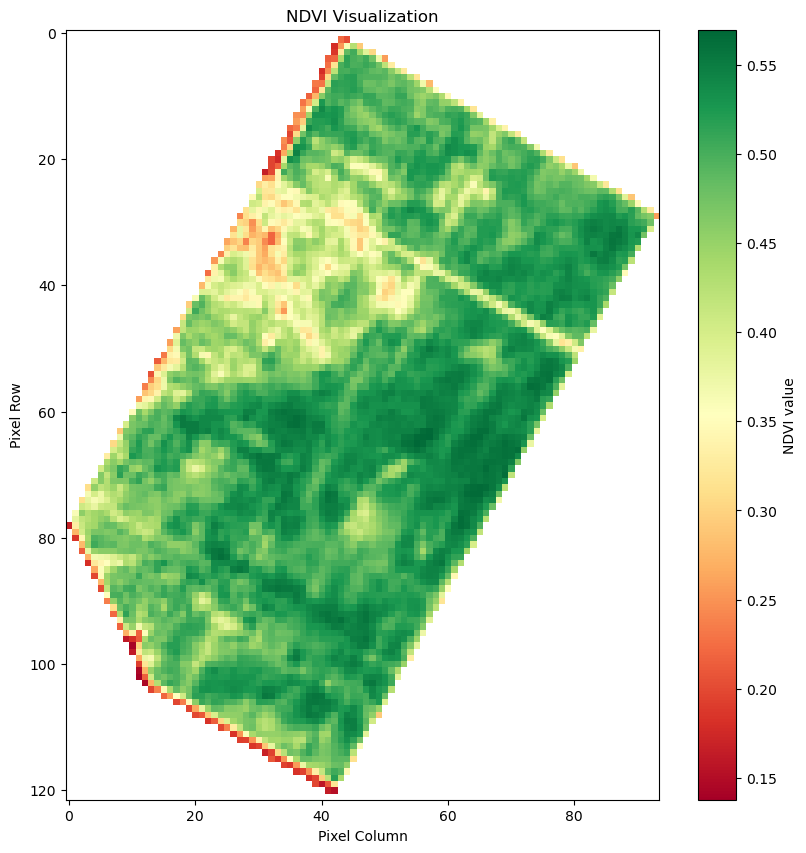

In [11]:
# Mostrar los datos de NDVI como una imagen, excluyendo los valores 0
plt.figure(figsize=(10, 10))
plt.imshow(ndvi_masked, cmap='RdYlGn')
plt.colorbar(label='NDVI value')
plt.title('NDVI Visualization')
plt.xlabel('Pixel Column')
plt.ylabel('Pixel Row')
plt.show()

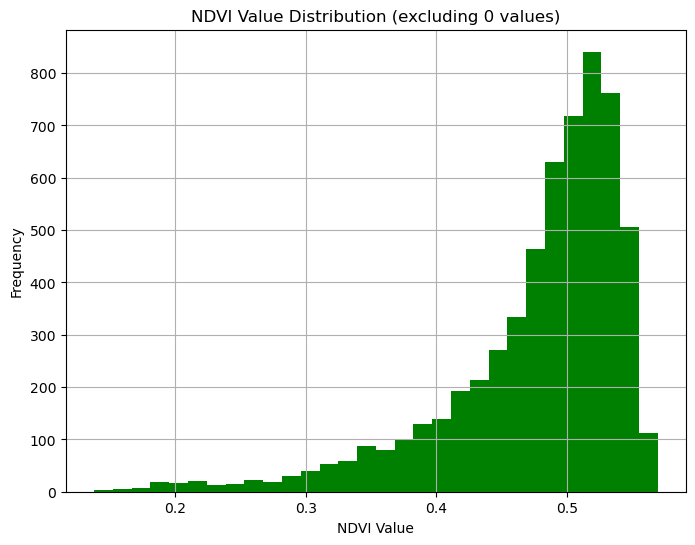

In [12]:
# Histograma de los valores de NDVI, excluyendo los valores 0
plt.figure(figsize=(8, 6))
plt.hist(ndvi_masked.compressed(), bins=30, color='green')
plt.title('NDVI Value Distribution (excluding 0 values)')
plt.xlabel('NDVI Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [14]:
ndvi_list = ndvi_masked.flatten().tolist()

In [15]:
with rasterio.open(r'C:\Test\res.tif') as src:
    ndvi_data = src.read(1)  # Leer la primera banda
    ndvi_values = ndvi_data[ndvi_data != 0]  # Excluir valores 0

# Convertir los valores a una lista
ndvi_list = ndvi_values.flatten().tolist()

In [16]:
len(ndvi_list)

5906

In [17]:
breaks = jenkspy.jenks_breaks(ndvi_list, n_classes=8)

In [18]:
breaks

[0.13768844306468964,
 0.25388601422309875,
 0.332182914018631,
 0.3887861967086792,
 0.4339740574359894,
 0.47137635946273804,
 0.5021148324012756,
 0.5291232466697693,
 0.5697399377822876]

In [19]:
# Ruta al archivo .tif
raster_path = r'C:\Test\res.tif'

In [71]:
# Define tus umbrales para la clasificación del NDVI
breaks = [0.0, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

In [19]:
breaks

[0.13768844306468964,
 0.25388601422309875,
 0.332182914018631,
 0.3887861967086792,
 0.4339740574359894,
 0.47137635946273804,
 0.5021148324012756,
 0.5291232466697693,
 0.5697399377822876]

In [20]:
with rasterio.open(raster_path) as src:
    ndvi = src.read(1)  # Asume que NDVI está en la primera banda
    profile = src.profile

    # Inicializa una imagen con -1 (representando una categoría no clasificada)
    NDVI_class = np.full(ndvi.shape, -1.0, dtype=np.float32)

    # Clasifica los valores de NDVI en categorías
    for i, threshold in enumerate(breaks):
        NDVI_class = np.where((ndvi >= threshold) & (NDVI_class == -1.0), i + 1, NDVI_class)

    # Asegurarse de que la última categoría capture todos los valores por encima del último umbral
    NDVI_class = np.where(ndvi >= breaks[-1], len(breaks), NDVI_class)

In [21]:
# Opcionalmente, guarda el resultado como un nuevo archivo raster
output_path = r'C:\Test\res_class.tif'
with rasterio.open(output_path, 'w', **profile) as dst:
    dst.write(NDVI_class.astype(rasterio.float32), 1)

In [22]:
ndvi[100]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.19196193, 0.31914893, 0.39016017, 0.44619462,
       0.48722574, 0.49757868, 0.49746042, 0.46306735, 0.46067417,
       0.41604155, 0.44616747, 0.49391872, 0.49837518, 0.5032525 ,
       0.50609213, 0.5043245 , 0.51457465, 0.5123123 , 0.5098694 ,
       0.5066052 , 0.5052308 , 0.49241045, 0.4798179 , 0.48777506,
       0.5112736 , 0.5254135 , 0.5016413 , 0.5014837 , 0.5157399 ,
       0.5152582 , 0.5236994 , 0.5346705 , 0.5355751 , 0.54327065,
       0.54997146, 0.54297215, 0.52246696, 0.5095231 , 0.51691675,
       0.50860536, 0.5050908 , 0.49754867, 0.44851658, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [23]:
NDVI_class[100]

array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1.], dtype=float32)

In [24]:
# Ruta al archivo .tif
raster_path = r'C:\Test\res_class.tif'

In [25]:
# Leer el archivo raster clasificado
with rasterio.open(output_path) as src:
    NDVI_classified = src.read(1)  # Asume que los datos clasificados están en la primera banda

# Definir una paleta de colores para las diferentes categorías
cmap = plt.cm.get_cmap('viridis', len(breaks))  # 'viridis' es solo un ejemplo, puedes elegir cualquier colormap disponible

C:\Users\Usuario\AppData\Local\Temp\ipykernel_15420\1626232323.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', len(breaks))  # 'viridis' es solo un ejemplo, puedes elegir cualquier colormap disponible


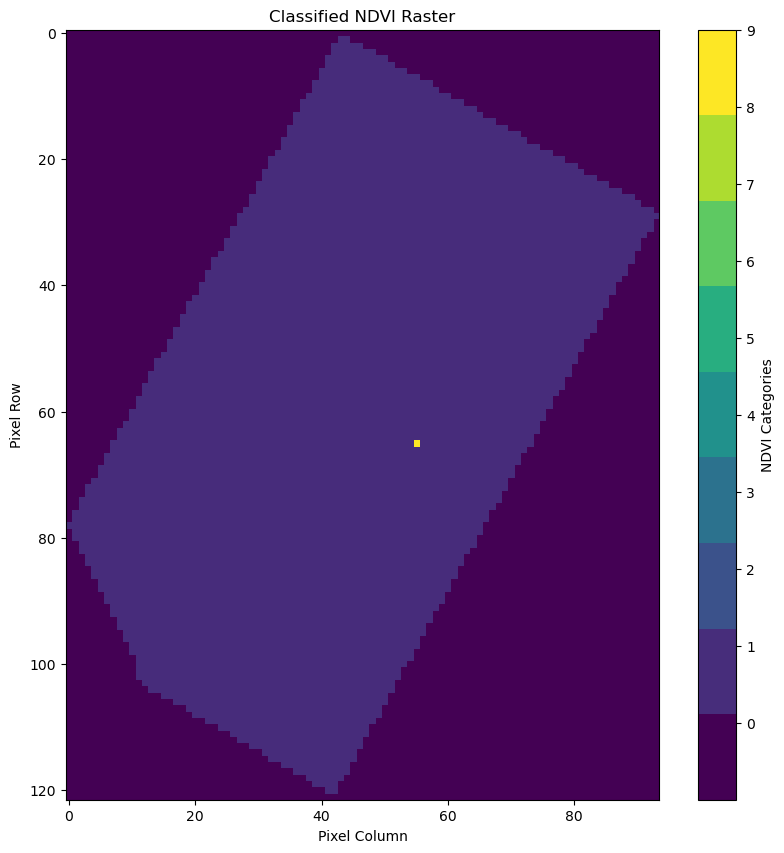

In [26]:
# Mostrar la imagen clasificada
plt.figure(figsize=(10, 10))
plt.imshow(NDVI_classified, cmap=cmap)
plt.colorbar(ticks=range(len(breaks)+1), label='NDVI Categories')
plt.title('Classified NDVI Raster')
plt.xlabel('Pixel Column')
plt.ylabel('Pixel Row')
plt.show()

C:\Users\Usuario\AppData\Local\Temp\ipykernel_15420\2525477698.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', len(breaks) + 1)  # Ajusta el número de colores a los breaks + 1 para la categoría inicial


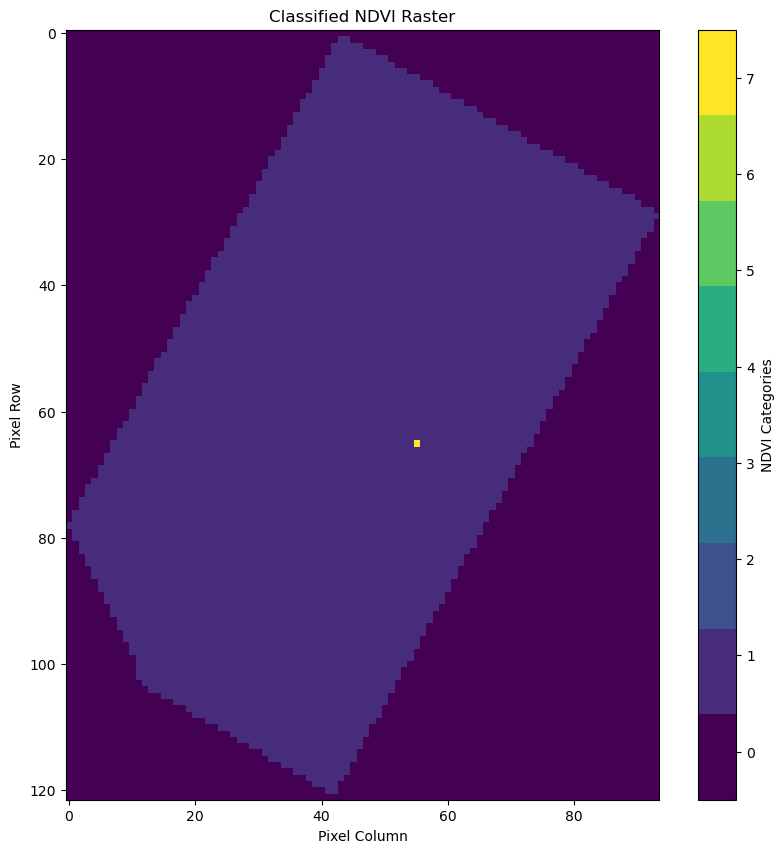

In [27]:

# Asumiendo que ya has definido 'breaks' en alguna parte de tu script, si no, define tus umbrales aquí
breaks = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]  # Ejemplo de umbrales

# Ruta al archivo raster clasificado
output_path = r'C:\Test\res_class.tif'  # Asegúrate de usar tu ruta correcta

# Leer el archivo raster clasificado
with rasterio.open(output_path) as src:
    NDVI_classified = src.read(1)  # Asume que los datos clasificados están en la primera banda

# Preparar la visualización con una paleta de colores adecuada
cmap = plt.cm.get_cmap('viridis', len(breaks) + 1)  # Ajusta el número de colores a los breaks + 1 para la categoría inicial

# Crear las etiquetas para la barra de color
labels = np.arange(len(breaks) + 1)
ticks = labels + 0.5

# Mostrar la imagen clasificada
plt.figure(figsize=(10, 10))
img = plt.imshow(NDVI_classified, cmap=cmap, vmin=0, vmax=len(breaks))
cbar = plt.colorbar(img, ticks=ticks, spacing='proportional')
cbar.set_ticklabels(labels)
cbar.set_label('NDVI Categories')

plt.title('Classified NDVI Raster')
plt.xlabel('Pixel Column')
plt.ylabel('Pixel Row')
plt.show()